# Audio Classification of Urban Sound using CNN

This notebook will explore and aim to classify the various sounds that can be found in an urban setting. Within this dataset, there are 10 classes of sound. The data is split into 10 folds that will be used to train and test the model.

**The outline of this project is as follows**:
1. *Import dataset*


2. *Explore the dataset*
    - exploration will entail looking at the specific audio features using a 'librosa'
    - visualise the spectograms
    
    
3. *Feature Extraction and Preparation*
    - extract mfccs, which are the features of the audio files
    - normalise the data
    
    
4. *Build Baseline Model*
    - evaluate results
    
    
5. *Build another Model and compare results with baseline*
    - when selecting a model, choose direction, not the depth of a single path
    - try and beat baseline model
    - evaluate new results and compare with baseline
    
    
6. *Hyperparameter Tuning*



(reference: https://twitter.com/svpino/status/1527620172625813504)

### 1. Import Libraries and Dataset

In [826]:
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import warnings

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
import keras
from tensorflow.keras import Sequential, layers, regularizers
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, MaxPool2D, Reshape
from sklearn.metrics import confusion_matrix, classification_report
import librosa.display
import librosa
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [827]:
warnings.filterwarnings("ignore")

In [828]:
meta = pd.read_csv('/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K/metadata/UrbanSound8K.csv')

### 2. Explore the Data

In [829]:
meta.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Training data

In [830]:
train = meta[meta['fold'].isin([1,2,3,4,6])]

In [831]:
test = meta[meta['fold'].isin([5,7,8,9,10])]

In [832]:
train.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
14,100652-3-0-0.wav,100652,0.000000,4.000000,1,2,3,dog_bark
15,100652-3-0-1.wav,100652,0.500000,4.500000,1,2,3,dog_bark
16,100652-3-0-2.wav,100652,1.000000,5.000000,1,2,3,dog_bark
17,100652-3-0-3.wav,100652,1.500000,5.500000,1,2,3,dog_bark
53,101281-3-0-0.wav,101281,0.341333,4.341333,2,6,3,dog_bark


In [833]:
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

Train Shape: (4499, 8)
Test Shape: (4233, 8)


In [834]:
meta.isna().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [835]:
classes = meta.groupby('classID')['class'].unique()

In [836]:
classes

classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object

In [837]:
# lets observe sample audio files in their respective spectogram form
df1, sr1 = librosa.load('/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K/audio/fold4/7064-6-1-0.wav')
df2, sr2 = librosa.load('/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K/audio/fold4/22883-7-10-0.wav')

Text(0.5, 1.0, 'Linear-frequency power spectogram')

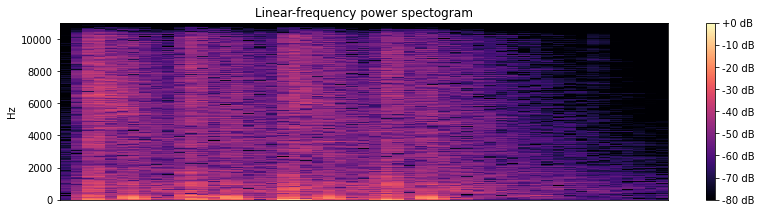

In [838]:
plt.figure(figsize=(30, 15))

d1 = librosa.amplitude_to_db(np.abs(librosa.stft(df1)), ref=np.max)
d2 = librosa.amplitude_to_db(np.abs(librosa.stft(df2)), ref=np.max)

plt.subplot(4,2,1)
librosa.display.specshow(d1, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectogram')

Text(0.5, 1.0, 'Linear-frequency power spectogram')

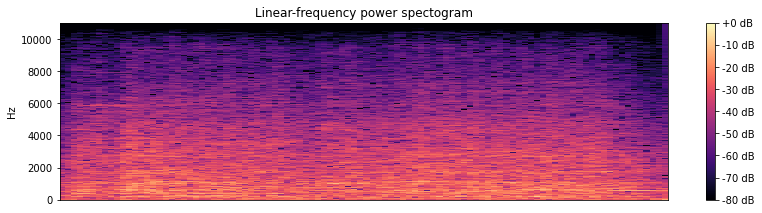

In [839]:
plt.figure(figsize=(30, 15))

d2 = librosa.amplitude_to_db(np.abs(librosa.stft(df2)), ref=np.max)

plt.subplot(4,2,1)
librosa.display.specshow(d2, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectogram')

In [840]:
arr = np.array(meta['slice_file_name'])
fold = np.array(meta['fold'])
class_ = np.array(meta['class'])

type(arr), type(fold), type(class_)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

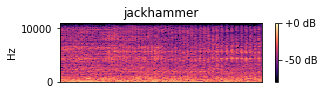

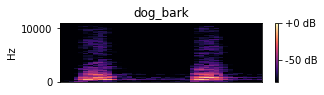

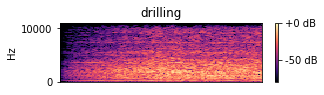

In [841]:
for i in range(192, 197, 2):
    file = "/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K/audio/fold" + str(fold[i]) + '/' + arr[i]
    data, sr = librosa.load(file)
    plt.figure(figsize=(10,5))
    d = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4,2,1)
    librosa.display.specshow(d, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(class_[i])

In [842]:
arr = librosa.feature.melspectrogram(y=df1, sr=sr)
arr.shape

(128, 53)

### 3. Feature Extraction and Preparation

In [843]:
# extract numeric features
def feature_extractor(file):
    data, sample_rate = librosa.load(file)
    data = librosa.feature.mfcc(data, n_mfcc = 15)
    data = np.mean(data, axis=0)
    return data

### Compile train set

In [844]:
feature = []
label = []


for i, rows in tqdm(train.iterrows()): # index over rows within the DF
    file = "/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K" + "/audio" + "/fold" + str(rows['fold']) + '/' + str(rows['slice_file_name'])
    
    # kaiser is a fast extraction method
    X, sr = librosa.load(file, res_type='kaiser_fast')
    
    # extract mfccs
    mfccs = np.mean(librosa.feature.melspectrogram(y=X, sr=sr).T, axis=0)
    
    # append features and labels to lists
    feature.append(mfccs)
    label.append(meta['classID'][i])

4499it [05:13, 14.36it/s]


In [878]:
X_train = np.array(feature)
X_train.shape

(4499, 128)

In [879]:
y_train = np.array(label)
y_train.shape

(4499,)

In [880]:
y_train = to_categorical(y_train)
y_train.shape

(4499, 10)

### Compile Test set

In [848]:
feature_test = []
label_test = []


for i, rows in tqdm(test.iterrows()): # index over rows within the DF
    file = "/Users/andrewcosta/Desktop/Milan/Machine Learning/data/UrbanSound8K" + "/audio" + "/fold" + str(rows['fold']) + '/' + str(rows['slice_file_name'])
    
    # kaiser is a fast extraction method
    X1, sr1 = librosa.load(file, res_type='kaiser_fast')
    
    # extract mfccs
    mfccs = np.mean(librosa.feature.melspectrogram(y=X1, sr=sr1).T, axis=0)
    
    # append features and labels to lists
    feature_test.append(mfccs)
    label_test.append(meta['classID'][i])

4233it [04:52, 14.45it/s]


In [881]:
X_test = np.array(feature_test)
X_test.shape

(4233, 128)

In [882]:
y_test = np.array(label_test)
y_test.shape

(4233,)

In [883]:
y_test = to_categorical(y_test)
y_test.shape

(4233, 10)

In [884]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4499, 128)
Shape of y_train: (4499, 10)
Shape of X_test: (4233, 128)
Shape of y_test: (4233, 10)


In [885]:
X_train = X_train.reshape(4499, 16, 8,1)
X_test = X_test.reshape(4233, 16, 8,1)
X_train.shape, X_test.shape

((4499, 16, 8, 1), (4233, 16, 8, 1))

In [886]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.333)

In [887]:
# set the input shape of the model
input_dim = (16,8,1)

In [655]:
model1 = Sequential()
# build the model
model1.add(Conv2D(300, (3,3), padding = 'same', activation = 'relu', input_shape=input_dim))
model1.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model1.add(Flatten())
model1.add(Dense(300, activation = 'relu'))
model1.add(Dense(10, activation = 'softmax')) # softmax: outputss a probability distribution over the 10 classes
                                                  # for every input sample, the model will output a 10-dimensional vector,
                                                  # where output[i] is the probability it belongs to a certain class i. 
                                                  # the 10 scores will sum to 1 
            #64
            #128
            #1024

In [568]:

    # compile the model
model1.compile(loss='categorical_crossentropy', # categorical crossentropy: measures the distance between the two 
                   optimizer='adam',             # probability distributions - output of network and true labels
                   metrics=['accuracy'])
    
    
    # fit the model
history1 = model1.fit(X_train,
                          y_train, 
                          epochs=50,
                          batch_size= 32,
                         validation_data = (X_val, y_val))

Epoch 1/50
49/49 [==============================] - 3s 52ms/step - loss: 3.6293 - accuracy: 0.2399 - val_loss: 2.1468 - val_accuracy: 0.3573
Epoch 2/50
49/49 [==============================] - 2s 51ms/step - loss: 1.7760 - accuracy: 0.4082 - val_loss: 1.8190 - val_accuracy: 0.4614
Epoch 3/50
49/49 [==============================] - 2s 47ms/step - loss: 1.6070 - accuracy: 0.4884 - val_loss: 1.7376 - val_accuracy: 0.4730
Epoch 4/50
49/49 [==============================] - 2s 47ms/step - loss: 1.4795 - accuracy: 0.5222 - val_loss: 1.7182 - val_accuracy: 0.4807
Epoch 5/50
49/49 [==============================] - 3s 56ms/step - loss: 1.4220 - accuracy: 0.5385 - val_loss: 1.4858 - val_accuracy: 0.5360
Epoch 6/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1562 - accuracy: 0.5972 - val_loss: 1.5335 - val_accuracy: 0.5514
Epoch 7/50
49/49 [==============================] - 2s 43ms/step - loss: 1.0864 - accuracy: 0.6378 - val_loss: 1.4794 - val_accuracy: 0.6028
Epoch 8/50
49

In [560]:
model1.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 16, 8, 300)        3000      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 8, 4, 300)         0         
_________________________________________________________________
flatten_82 (Flatten)         (None, 9600)              0         
_________________________________________________________________
dense_167 (Dense)            (None, 300)               2880300   
_________________________________________________________________
dense_168 (Dense)            (None, 10)                3010      
Total params: 2,886,310
Trainable params: 2,886,310
Non-trainable params: 0
_________________________________________________________________


In [569]:
import sklearn.metrics as metrics
y_pred = model1.predict_classes(X_test)

In [570]:
print("Accuracy:",metrics.accuracy_score(np.argmax(y_test, axis=1),y_pred))
print("f1_weighted:",metrics.f1_score(np.argmax(y_test, axis=1), y_pred,average='weighted'))

Accuracy: 0.4842901015828018
f1_weighted: 0.4801959820151658


In [589]:
predictions = model1.predict(X_test)
score_val, acc_val = model1.evaluate(X_val, y_val, verbose=0)
score_train, acc_train = model1.evaluate(X_train, y_train, verbose=0)
print(f'Val Accuracy: {acc_val}')
print(f'Train Accuracy: {acc_train}')

Val Accuracy: 0.76606684923172
Train Accuracy: 0.9241645336151123


In [572]:
train_hist1 = pd.DataFrame(history1.history)

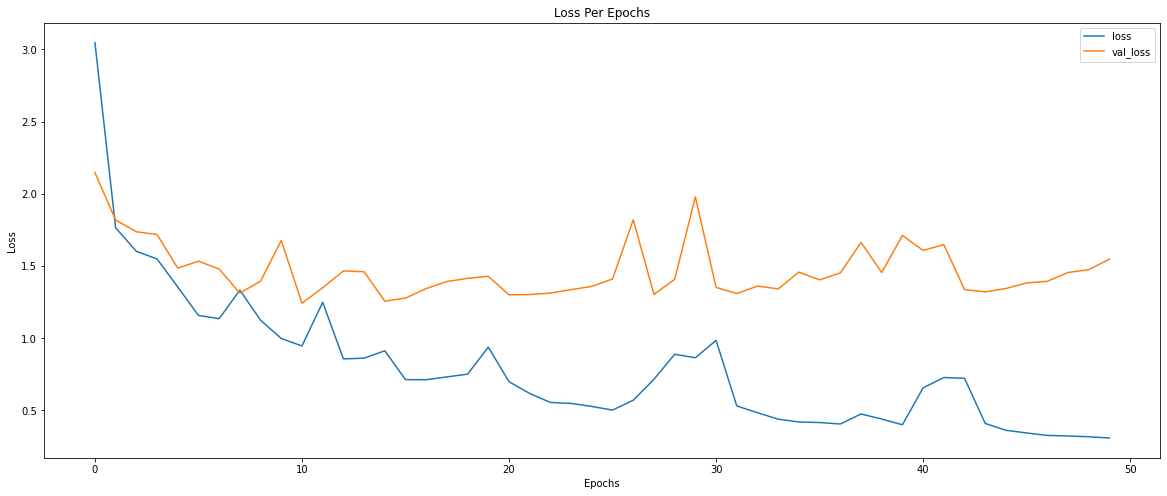

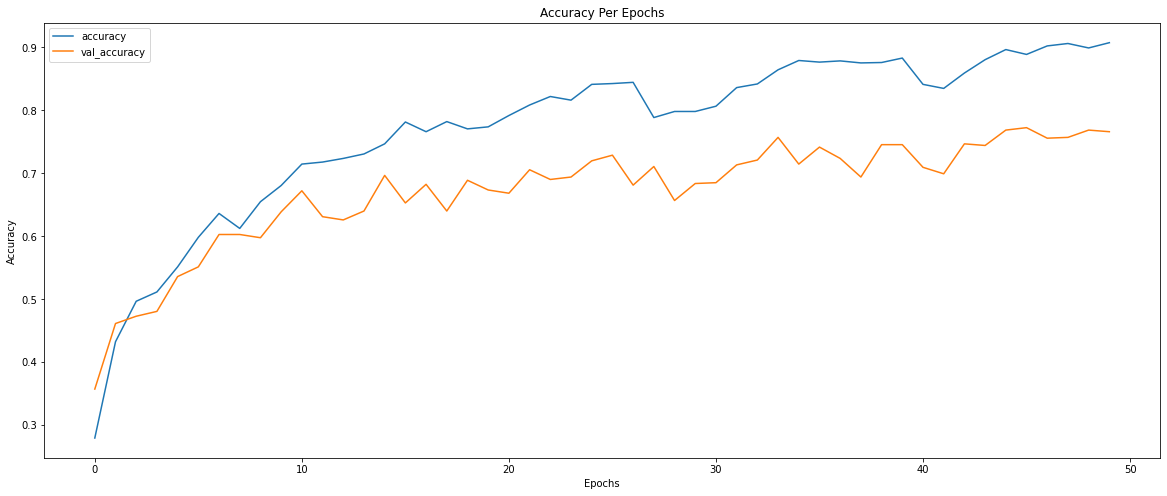

In [573]:
plt.figure(figsize=(20,8))
plt.plot(train_hist1[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist1[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [574]:
ytrue = np.argmax(y_val,axis=1)
ypred = np.argmax(model1.predict(X_val),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[83  0  4  0  1  1  0  1  2  1]
 [ 2 22  0  3  1  1  0  2  1  3]
 [ 3  0 49 11  2  0  1  1 16 13]
 [ 2  0  7 61  4  0  2  1  7  3]
 [ 1  2  3  0 64  0  1  3  1  6]
 [ 3  0  3  0  0 76  0  0  1  2]
 [ 2  0  3  1  0  0 35  1  0  0]
 [ 2  0  1  0  2  0  0 75  3  1]
 [ 3  0  0  5  1  2  0  0 86  0]
 [ 3  1 10  6  6  1  0  2  4 45]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.89      0.84        93
           1       0.88      0.63      0.73        35
           2       0.61      0.51      0.56        96
           3       0.70      0.70      0.70        87
           4       0.79      0.79      0.79        81
           5       0.94      0.89      0.92        85
           6       0.90      0.83      0.86        42
           7       0.87      0.89      0.88        84
           8       0.71      0.89      0.79        97
           9       0.61      0.58      0.59        78

    accuracy          

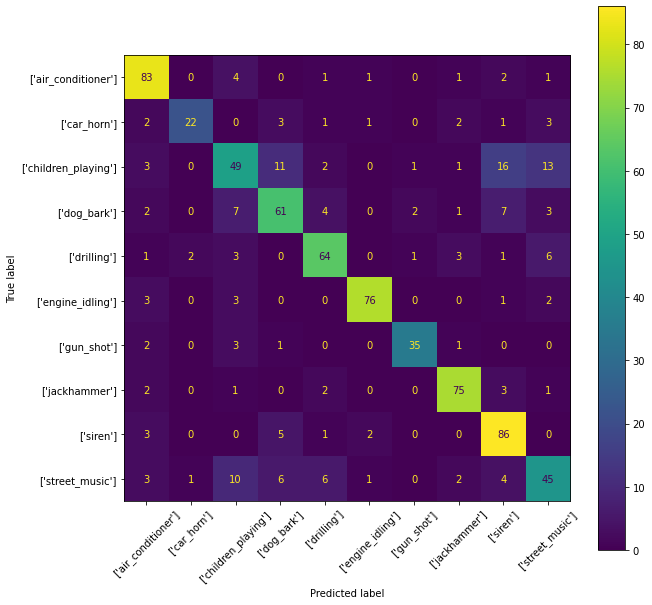

In [575]:
cm = confusion_matrix(ytrue, ypred)
cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classes)

fig, ax = plt.subplots(figsize=(10,10))

cm_plt.plot(ax=ax)
plt.xticks(rotation = 45)
plt.show()

In [576]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model1.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[184   4  27  19  32 104  28  18   3  81]
 [  1 155  10   7  12   4   0   4   7  21]
 [ 35   1 206  51  23  30   5  13  85  51]
 [ 17   5  37 331  18  17   0   4  54  17]
 [ 24   9  11  36 201  13   7 122  14  63]
 [103   4  45  10  28 152  47  24   7  63]
 [  1   0  31   1   5   6 111  18   6   5]
 [  4   0  16   2 171  12  33 159   1  54]
 [ 23   8  25  15   7  12   0  11 282  10]
 [ 52   8  27  39  44  10   4  28  19 269]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.41      0.37      0.39       500
           1       0.80      0.70      0.75       221
           2       0.47      0.41      0.44       500
           3       0.65      0.66      0.65       500
           4       0.37      0.40      0.39       500
           5       0.42      0.31      0.36       483
           6       0.47      0.60      0.53       184
           7       0.40      0.35      0.37       452
           8       0.59      0.

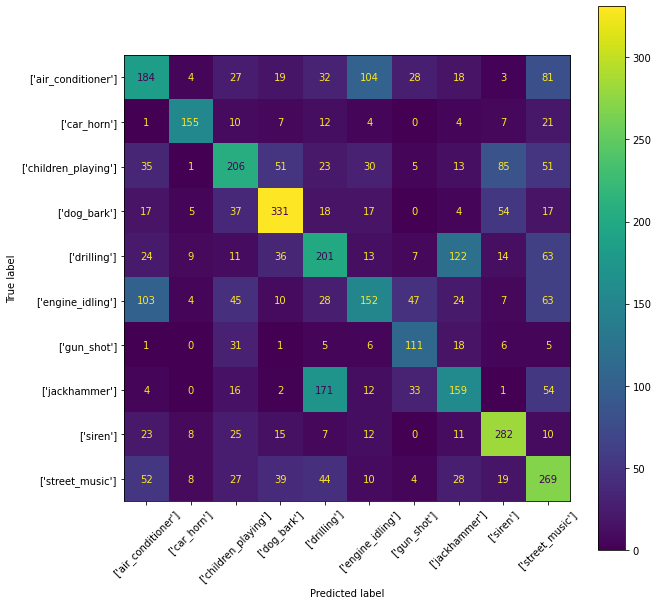

In [577]:
cm = confusion_matrix(ytrue, ypred)
cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classes)

fig, ax = plt.subplots(figsize=(10,10))

cm_plt.plot(ax=ax)
plt.xticks(rotation = 45)
plt.show()

## Model 2 - Simpler Model Architecture to Reduce Overfitting

In [578]:
base = Sequential()
base.add(Conv2D(64, (3,3), activation='relu', input_shape=input_dim))
base.add(Flatten())
base.add(Dense(64, activation='relu'))
base.add(Dense(10, activation='softmax'))
    
base.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy']
                       )
    
base_hist = base.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
49/49 [==============================] - 1s 16ms/step - loss: 2.5047 - accuracy: 0.2724 - val_loss: 1.8789 - val_accuracy: 0.3728
Epoch 2/50
49/49 [==============================] - 0s 9ms/step - loss: 1.8494 - accuracy: 0.4564 - val_loss: 1.7317 - val_accuracy: 0.4794
Epoch 3/50
49/49 [==============================] - 0s 9ms/step - loss: 1.4728 - accuracy: 0.5227 - val_loss: 1.6255 - val_accuracy: 0.5398
Epoch 4/50
49/49 [==============================] - 0s 9ms/step - loss: 1.3673 - accuracy: 0.5476 - val_loss: 1.5538 - val_accuracy: 0.5206
Epoch 5/50
49/49 [==============================] - 1s 14ms/step - loss: 1.1551 - accuracy: 0.6227 - val_loss: 1.5596 - val_accuracy: 0.5167
Epoch 6/50
49/49 [==============================] - 1s 11ms/step - loss: 1.1120 - accuracy: 0.6479 - val_loss: 1.4690 - val_accuracy: 0.6170
Epoch 7/50
49/49 [==============================] - 1s 17ms/step - loss: 1.0064 - accuracy: 0.6947 - val_loss: 1.6328 - val_accuracy: 0.6080
Epoch 8/50
49/49

In [584]:
base.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 14, 6, 64)         640       
_________________________________________________________________
flatten_84 (Flatten)         (None, 5376)              0         
_________________________________________________________________
dense_171 (Dense)            (None, 64)                344128    
_________________________________________________________________
dense_172 (Dense)            (None, 10)                650       
Total params: 345,418
Trainable params: 345,418
Non-trainable params: 0
_________________________________________________________________


In [580]:
base_hist1 = pd.DataFrame(base_hist.history)

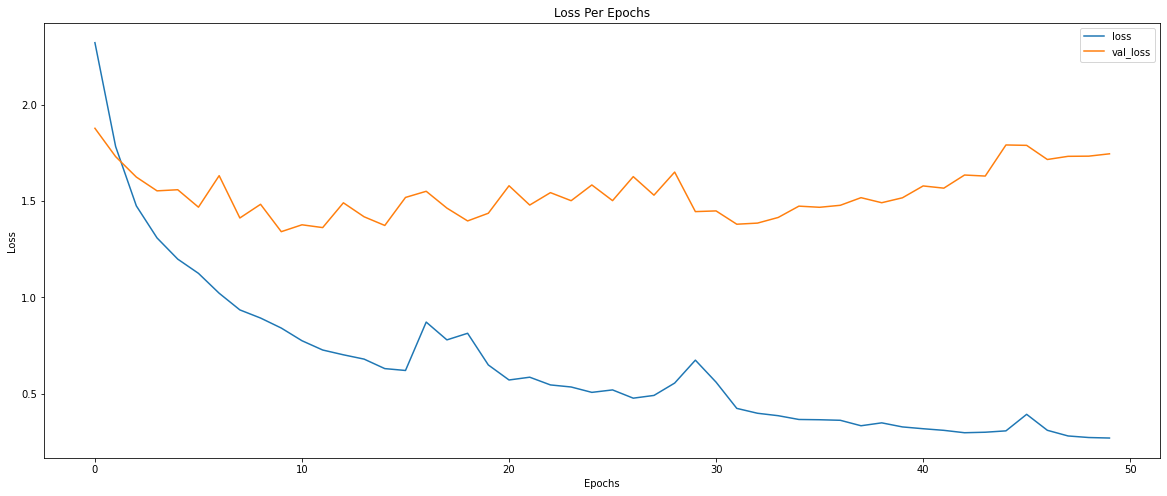

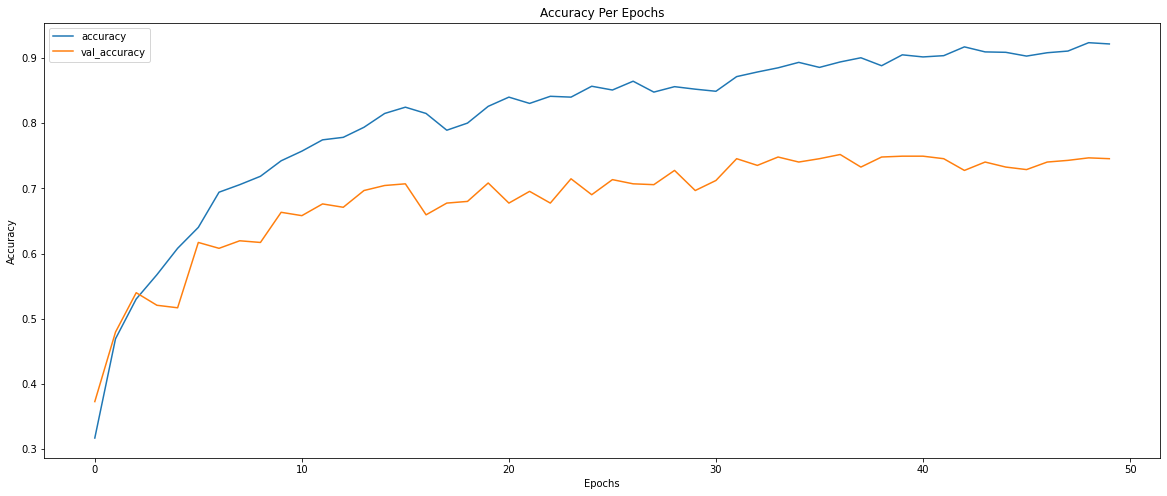

In [581]:
plt.figure(figsize=(20,8))
plt.plot(base_hist1[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(base_hist1[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [582]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(base.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))


Confusion Matrix :


[[255   1  55  14  61   9   4  13   1  87]
 [  5 139  24   7  20   9   0   4   1  12]
 [ 37   3 275  55  28  29   1  18  19  35]
 [ 14   6  87 257  40  16   0  10  35  35]
 [ 20  22  56  45 209  14   1  90   4  39]
 [150   6  92   5   3 130   0  42   1  54]
 [  6   0  40   6  11   3 103  11   1   3]
 [ 10   2  28   8 243   4  17  83   0  57]
 [ 16  10  45  79  15  18   0   9 196   5]
 [ 34  18  56  44  41  18   0  40  21 228]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.47      0.51      0.49       500
           1       0.67      0.63      0.65       221
           2       0.36      0.55      0.44       500
           3       0.49      0.51      0.50       500
           4       0.31      0.42      0.36       500
           5       0.52      0.27      0.35       483
           6       0.82      0.56      0.66       184
           7       0.26      0.18      0.22       452
           8       0.70      0.

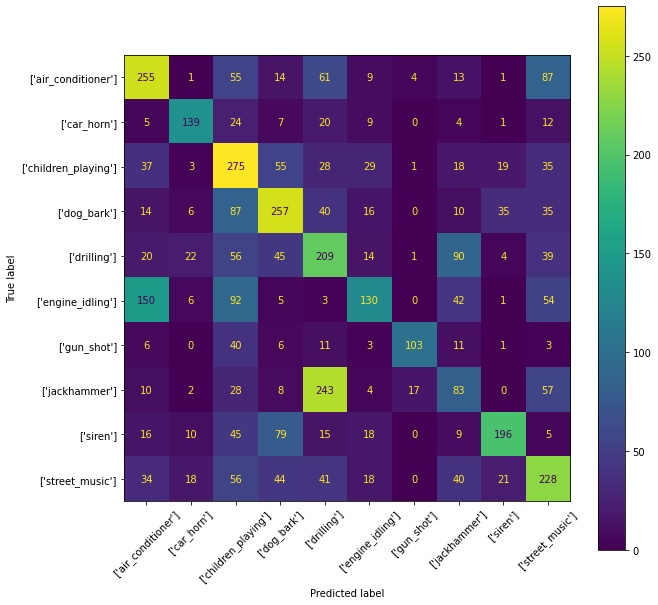

In [583]:
cm = confusion_matrix(ytrue, ypred)
cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classes)

fig, ax = plt.subplots(figsize=(10,10))

cm_plt.plot(ax=ax)
plt.xticks(rotation = 45)
plt.show()

In [585]:
y_pred = base.predict_classes(X_test)

In [586]:
print("Accuracy:",metrics.accuracy_score(np.argmax(y_test, axis=1),y_pred))

Accuracy: 0.44294826364280654


In [588]:
predictions_base = base.predict(X_test)
score_val, acc_val = base.evaluate(X_val, y_val, verbose=0)
score_train, acc_train = base.evaluate(X_train, y_train, verbose=0)
print(f'Val Accuracy: {acc_val}')
print(f'Train Accuracy: {acc_train}')

Val Accuracy: 0.7455012798309326
Train Accuracy: 0.923521876335144


## Model 3 - KFold

## K-Fold

In [363]:
Kmodel = KerasClassifier(build_fn=base, verbose=1)

In [371]:
kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

In [591]:
X_train = np.array(feature)
X_train.shape

(4499, 128)

In [592]:
y_train = np.array(label)
y_train.shape

(4499,)

In [594]:
X_train = X_train.reshape(4499, 16, 8,1)

In [595]:
cvscores = []

for train, val in kFold.split(X_train, y_train):
    base = Sequential()
    base.add(Conv2D(64, (3,3), activation='relu', input_shape=input_dim))
    base.add(Flatten())
    base.add(Dense(64, activation='relu'))
    base.add(Dense(10, activation='softmax'))
    
    base.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy']
                       )
    
    base.fit(X_train[train], y_train[train], epochs=50, batch_size=32)
    
    base.evaluate(X_train[val], y_train[val], verbose=0)
    
    cvscores.append(scores[1] * 100)

Epoch 1/50
127/127 [==============================] - 2s 8ms/step - loss: 2.4521 - accuracy: 0.2841
Epoch 2/50
127/127 [==============================] - 1s 7ms/step - loss: 1.4545 - accuracy: 0.5200
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: 1.3204 - accuracy: 0.5801
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: 1.1044 - accuracy: 0.6556
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: 0.9932 - accuracy: 0.6887
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: 0.9644 - accuracy: 0.7139
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: 0.8006 - accuracy: 0.7486
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: 0.7626 - accuracy: 0.7696
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: 0.7377 - accuracy: 0.7760
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: 0.6909 - accuracy: 0.7917

127/127 [==============================] - 1s 7ms/step - loss: 0.3273 - accuracy: 0.8967
Epoch 33/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2785 - accuracy: 0.9119
Epoch 34/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2712 - accuracy: 0.9183
Epoch 35/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2792 - accuracy: 0.9171
Epoch 36/50
127/127 [==============================] - 1s 7ms/step - loss: 0.2910 - accuracy: 0.9282
Epoch 37/50
127/127 [==============================] - 1s 7ms/step - loss: 0.2458 - accuracy: 0.9176
Epoch 38/50
127/127 [==============================] - 1s 9ms/step - loss: 0.3091 - accuracy: 0.9118
Epoch 39/50
127/127 [==============================] - 1s 9ms/step - loss: 0.2406 - accuracy: 0.9206
Epoch 40/50
127/127 [==============================] - 1s 11ms/step - loss: 0.2369 - accuracy: 0.9337
Epoch 41/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2445 - accuracy: 0.9285
E

127/127 [==============================] - 1s 9ms/step - loss: 0.6297 - accuracy: 0.8096
Epoch 13/50
127/127 [==============================] - 1s 8ms/step - loss: 0.5695 - accuracy: 0.8244
Epoch 14/50
127/127 [==============================] - 1s 8ms/step - loss: 0.5843 - accuracy: 0.8259
Epoch 15/50
127/127 [==============================] - 1s 8ms/step - loss: 0.5037 - accuracy: 0.8322
Epoch 16/50
127/127 [==============================] - 1s 8ms/step - loss: 0.4647 - accuracy: 0.8612
Epoch 17/50
127/127 [==============================] - 1s 9ms/step - loss: 0.4959 - accuracy: 0.8474
Epoch 18/50
127/127 [==============================] - 1s 8ms/step - loss: 0.4736 - accuracy: 0.8628
Epoch 19/50
127/127 [==============================] - 1s 8ms/step - loss: 0.4284 - accuracy: 0.8688
Epoch 20/50
127/127 [==============================] - 1s 8ms/step - loss: 0.4724 - accuracy: 0.8574
Epoch 21/50
127/127 [==============================] - 1s 8ms/step - loss: 0.4168 - accuracy: 0.8697
Ep

127/127 [==============================] - 1s 7ms/step - loss: 0.2456 - accuracy: 0.9234
Epoch 44/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2684 - accuracy: 0.9260
Epoch 45/50
127/127 [==============================] - 1s 7ms/step - loss: 0.2173 - accuracy: 0.9338
Epoch 46/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2088 - accuracy: 0.9408
Epoch 47/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2250 - accuracy: 0.9337
Epoch 48/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2292 - accuracy: 0.9256
Epoch 49/50
127/127 [==============================] - 1s 7ms/step - loss: 0.1914 - accuracy: 0.9426
Epoch 50/50
127/127 [==============================] - 1s 8ms/step - loss: 0.2163 - accuracy: 0.9348
Epoch 1/50
127/127 [==============================] - 2s 8ms/step - loss: 2.3213 - accuracy: 0.3179
Epoch 2/50
127/127 [==============================] - 1s 8ms/step - loss: 1.4188 - accuracy: 0.5387
Epoc

127/127 [==============================] - 1s 8ms/step - loss: 0.4151 - accuracy: 0.8735
Epoch 25/50
127/127 [==============================] - 1s 9ms/step - loss: 0.4301 - accuracy: 0.8836
Epoch 26/50
127/127 [==============================] - 1s 8ms/step - loss: 0.3610 - accuracy: 0.8921
Epoch 27/50
127/127 [==============================] - 1s 9ms/step - loss: 0.3575 - accuracy: 0.8908
Epoch 28/50
127/127 [==============================] - 1s 7ms/step - loss: 0.4570 - accuracy: 0.8661
Epoch 29/50
127/127 [==============================] - 1s 8ms/step - loss: 0.3613 - accuracy: 0.8853
Epoch 30/50
127/127 [==============================] - 1s 8ms/step - loss: 0.3615 - accuracy: 0.8942
Epoch 31/50
127/127 [==============================] - 1s 9ms/step - loss: 0.4066 - accuracy: 0.8941
Epoch 32/50
127/127 [==============================] - 1s 8ms/step - loss: 0.3457 - accuracy: 0.8985
Epoch 33/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3200 - accuracy: 0.9023
Ep

127/127 [==============================] - 1s 7ms/step - loss: 0.9520 - accuracy: 0.6963
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: 0.9209 - accuracy: 0.7068
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: 0.7935 - accuracy: 0.7556
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: 1.1740 - accuracy: 0.7337
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: 0.6881 - accuracy: 0.7843
Epoch 10/50
127/127 [==============================] - 1s 8ms/step - loss: 0.6892 - accuracy: 0.7871
Epoch 11/50
127/127 [==============================] - 1s 7ms/step - loss: 0.7909 - accuracy: 0.7921
Epoch 12/50
127/127 [==============================] - 1s 6ms/step - loss: 0.6429 - accuracy: 0.8152
Epoch 13/50
127/127 [==============================] - 1s 7ms/step - loss: 0.6044 - accuracy: 0.8123
Epoch 14/50
127/127 [==============================] - 1s 7ms/step - loss: 0.5830 - accuracy: 0.8226
Epoch 

127/127 [==============================] - 1s 6ms/step - loss: 0.2628 - accuracy: 0.9223
Epoch 36/50
127/127 [==============================] - 1s 6ms/step - loss: 0.2516 - accuracy: 0.9222
Epoch 37/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3200 - accuracy: 0.9054
Epoch 38/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3468 - accuracy: 0.9167
Epoch 39/50
127/127 [==============================] - 1s 6ms/step - loss: 0.4240 - accuracy: 0.9147
Epoch 40/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3289 - accuracy: 0.9136
Epoch 41/50
127/127 [==============================] - 1s 6ms/step - loss: 0.2460 - accuracy: 0.9299
Epoch 42/50
127/127 [==============================] - 1s 7ms/step - loss: 0.2450 - accuracy: 0.9292
Epoch 43/50
127/127 [==============================] - 1s 6ms/step - loss: 0.2507 - accuracy: 0.9281
Epoch 44/50
127/127 [==============================] - 1s 6ms/step - loss: 0.2074 - accuracy: 0.9391
Ep

In [596]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

50.44% (+/- 0.00%)


In [600]:
kFold2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

In [601]:
cvscores2 = []

for train, val in kFold2.split(X_train, y_train):
    base = Sequential()
    base.add(Conv2D(64, (3,3), activation='relu', input_shape=input_dim))
    base.add(Flatten())
    base.add(Dense(64, activation='relu'))
    base.add(Dense(10, activation='softmax'))
    
    base.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy']
                       )
    
    base.fit(X_train[train], y_train[train], epochs=50, batch_size=32)
    
    base.evaluate(X_train[val], y_train[val], verbose=0)
    
    cvscores2.append(scores[1] * 100)

Epoch 1/50
113/113 [==============================] - 1s 7ms/step - loss: 2.9723 - accuracy: 0.2878
Epoch 2/50
113/113 [==============================] - 1s 7ms/step - loss: 1.5439 - accuracy: 0.4878
Epoch 3/50
113/113 [==============================] - 1s 9ms/step - loss: 1.3626 - accuracy: 0.5542
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 1.1827 - accuracy: 0.6160
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 1.0453 - accuracy: 0.6717
Epoch 6/50
113/113 [==============================] - 1s 6ms/step - loss: 1.0314 - accuracy: 0.6824
Epoch 7/50
113/113 [==============================] - 1s 7ms/step - loss: 0.9735 - accuracy: 0.7082
Epoch 8/50
113/113 [==============================] - 1s 6ms/step - loss: 0.8580 - accuracy: 0.7340
Epoch 9/50
113/113 [==============================] - 1s 7ms/step - loss: 0.8014 - accuracy: 0.7476
Epoch 10/50
113/113 [==============================] - 1s 11ms/step - loss: 0.7241 - accuracy: 0.778

113/113 [==============================] - 1s 7ms/step - loss: 0.3390 - accuracy: 0.8956
Epoch 32/50
113/113 [==============================] - 1s 6ms/step - loss: 0.3177 - accuracy: 0.9032
Epoch 33/50
113/113 [==============================] - 1s 6ms/step - loss: 0.2983 - accuracy: 0.9056
Epoch 34/50
113/113 [==============================] - 1s 8ms/step - loss: 0.3073 - accuracy: 0.9152
Epoch 35/50
113/113 [==============================] - 1s 7ms/step - loss: 0.3079 - accuracy: 0.9138
Epoch 36/50
113/113 [==============================] - 1s 7ms/step - loss: 0.2992 - accuracy: 0.9171
Epoch 37/50
113/113 [==============================] - 1s 7ms/step - loss: 0.2625 - accuracy: 0.9256
Epoch 38/50
113/113 [==============================] - 1s 7ms/step - loss: 0.2603 - accuracy: 0.9252
Epoch 39/50
113/113 [==============================] - 1s 7ms/step - loss: 0.2579 - accuracy: 0.9184
Epoch 40/50
113/113 [==============================] - 1s 6ms/step - loss: 0.2707 - accuracy: 0.9238
Ep

113/113 [==============================] - 1s 7ms/step - loss: 0.6117 - accuracy: 0.8086
Epoch 13/50
113/113 [==============================] - 1s 6ms/step - loss: 0.6555 - accuracy: 0.7886
Epoch 14/50
113/113 [==============================] - 1s 6ms/step - loss: 0.6771 - accuracy: 0.7893
Epoch 15/50
113/113 [==============================] - 1s 6ms/step - loss: 0.6284 - accuracy: 0.8185
Epoch 16/50
113/113 [==============================] - 1s 6ms/step - loss: 0.5925 - accuracy: 0.8222
Epoch 17/50
113/113 [==============================] - 1s 6ms/step - loss: 0.5462 - accuracy: 0.8296
Epoch 18/50
113/113 [==============================] - 1s 6ms/step - loss: 0.4793 - accuracy: 0.8446
Epoch 19/50
113/113 [==============================] - 1s 6ms/step - loss: 0.5125 - accuracy: 0.8529
Epoch 20/50
113/113 [==============================] - 1s 7ms/step - loss: 0.4411 - accuracy: 0.8571
Epoch 21/50
113/113 [==============================] - 1s 6ms/step - loss: 0.4635 - accuracy: 0.8643
Ep

113/113 [==============================] - 1s 9ms/step - loss: 0.2267 - accuracy: 0.9334
Epoch 44/50
113/113 [==============================] - 1s 10ms/step - loss: 0.2185 - accuracy: 0.9328
Epoch 45/50
113/113 [==============================] - 1s 12ms/step - loss: 0.1964 - accuracy: 0.9394
Epoch 46/50
113/113 [==============================] - 1s 9ms/step - loss: 0.2343 - accuracy: 0.9376
Epoch 47/50
113/113 [==============================] - 1s 9ms/step - loss: 0.4337 - accuracy: 0.8989
Epoch 48/50
113/113 [==============================] - 1s 10ms/step - loss: 0.3062 - accuracy: 0.9211
Epoch 49/50
113/113 [==============================] - 1s 8ms/step - loss: 0.3125 - accuracy: 0.9173
Epoch 50/50
113/113 [==============================] - 1s 9ms/step - loss: 0.2798 - accuracy: 0.9235


In [602]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))

50.44% (+/- 0.00%)


## Model 4

In [547]:
history2 = model1.fit(X_train, y_train,
           epochs=50,
          batch_size=32,
          )

Epoch 1/50
73/73 [==============================] - 5s 64ms/step - loss: 0.2166 - accuracy: 0.9503
Epoch 2/50
73/73 [==============================] - 5s 63ms/step - loss: 0.3434 - accuracy: 0.9434
Epoch 3/50
73/73 [==============================] - 5s 66ms/step - loss: 0.2653 - accuracy: 0.9434
Epoch 4/50
73/73 [==============================] - 4s 59ms/step - loss: 0.2770 - accuracy: 0.9477
Epoch 5/50
73/73 [==============================] - 4s 61ms/step - loss: 0.2101 - accuracy: 0.9512
Epoch 6/50
73/73 [==============================] - 4s 61ms/step - loss: 0.2258 - accuracy: 0.9477
Epoch 7/50
73/73 [==============================] - 5s 68ms/step - loss: 0.2488 - accuracy: 0.9499
Epoch 8/50
73/73 [==============================] - 4s 55ms/step - loss: 0.3148 - accuracy: 0.9516
Epoch 9/50
73/73 [==============================] - 5s 64ms/step - loss: 0.2196 - accuracy: 0.9460
Epoch 10/50
73/73 [==============================] - 5s 63ms/step - loss: 0.2180 - accuracy: 0.9499
Epoch 11/

KeyboardInterrupt: 

In [55]:
ytrue = np.argmax(y_test,axis=1)
preds1 = np.argmax(model1.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,preds1))
print('\n\nClassification Report : \n\n',classification_report(ytrue,preds1))


Confusion Matrix :


[[176   2  51  14  39  82  28   0   4 104]
 [  2 140  26   8  14   4   0   3   4  20]
 [ 27   0 301  32  15  36   2   3  58  26]
 [ 10   5  64 330  12  15   1   2  50  11]
 [ 23   9  24  29 230  17   7  52  14  95]
 [ 47  14  51  24   7 288   0   2  27  23]
 [  6   0  38   2   6   2 116   5   6   3]
 [ 23   1  22   8 247  27  43  64   1  16]
 [ 15   2  17  30   6  14   1   8 291   9]
 [ 33   3  61  36  34  16   2  15  15 285]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.49      0.35      0.41       500
           1       0.80      0.63      0.71       221
           2       0.46      0.60      0.52       500
           3       0.64      0.66      0.65       500
           4       0.38      0.46      0.41       500
           5       0.57      0.60      0.59       483
           6       0.58      0.63      0.60       184
           7       0.42      0.14      0.21       452
           8       0.62      0.

How to reduce overfitting:

1. Use simple cost and loss function
2. Use regularisation (e.g. Dropout)
3. Reduce number of learning parameters in model

## Reduce Model Overfitting

1. Early Stopping

In [652]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='my_model1.h5',
    monitor='val_loss',
    save_best_only=True,
    )
]

model1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history_es = model1.fit(X_train, y_train,
         epochs=50,
         callbacks=callbacks_list, 
         validation_data=(X_val, y_val))

Epoch 1/50
94/94 [==============================] - 5s 50ms/step - loss: 3.7496 - accuracy: 0.2710 - val_loss: 1.8748 - val_accuracy: 0.4063
Epoch 2/50
94/94 [==============================] - 5s 55ms/step - loss: 1.6024 - accuracy: 0.4701 - val_loss: 1.8698 - val_accuracy: 0.4683
Epoch 3/50
94/94 [==============================] - 4s 44ms/step - loss: 1.4935 - accuracy: 0.5238 - val_loss: 1.5398 - val_accuracy: 0.5177
Epoch 4/50
94/94 [==============================] - 5s 52ms/step - loss: 1.2774 - accuracy: 0.5833 - val_loss: 1.4731 - val_accuracy: 0.5530
Epoch 5/50
94/94 [==============================] - 4s 48ms/step - loss: 1.2084 - accuracy: 0.6052 - val_loss: 1.4489 - val_accuracy: 0.5564
Epoch 6/50
94/94 [==============================] - 5s 50ms/step - loss: 1.1072 - accuracy: 0.6392 - val_loss: 1.3100 - val_accuracy: 0.6171
Epoch 7/50
94/94 [==============================] - 4s 48ms/step - loss: 0.9743 - accuracy: 0.6779 - val_loss: 1.3385 - val_accuracy: 0.6024
Epoch 8/50
94

In [654]:
predictions_base = model1.predict(X_test)
score_val, acc_val = model1.evaluate(X_val, y_val, verbose=0)
score_train, acc_train = model1.evaluate(X_train, y_train, verbose=0)
y_pred = model1.predict_classes(X_test)
print("Test Accuracy:",metrics.accuracy_score(np.argmax(y_test, axis=1),y_pred))
print(f'Val Accuracy: {acc_val}')
print(f'Train Accuracy: {acc_train}')

Test Accuracy: 0.4670446491849752
Val Accuracy: 0.6917945146560669
Train Accuracy: 0.7793333530426025


2. Reduce LR On Plateau

In [657]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    )
]

model1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history_lr = model1.fit(X_train, y_train,
         epochs=50,
         batch_size=32, 
         callbacks=callbacks_list, 
         validation_data=(X_val, y_val))

Epoch 1/50
94/94 [==============================] - 7s 51ms/step - loss: 3.9828 - accuracy: 0.2581 - val_loss: 1.7090 - val_accuracy: 0.4356
Epoch 2/50
94/94 [==============================] - 5s 56ms/step - loss: 1.6175 - accuracy: 0.4726 - val_loss: 1.6827 - val_accuracy: 0.4616
Epoch 3/50
94/94 [==============================] - 5s 48ms/step - loss: 1.3680 - accuracy: 0.5663 - val_loss: 1.5680 - val_accuracy: 0.5337
Epoch 4/50
94/94 [==============================] - 6s 61ms/step - loss: 1.2536 - accuracy: 0.5972 - val_loss: 1.3598 - val_accuracy: 0.5924
Epoch 5/50
94/94 [==============================] - 4s 46ms/step - loss: 1.0987 - accuracy: 0.6351 - val_loss: 1.2687 - val_accuracy: 0.6458
Epoch 6/50
94/94 [==============================] - 4s 47ms/step - loss: 1.0326 - accuracy: 0.6790 - val_loss: 1.5283 - val_accuracy: 0.6024
Epoch 7/50
94/94 [==============================] - 5s 48ms/step - loss: 0.9004 - accuracy: 0.7162 - val_loss: 1.3369 - val_accuracy: 0.6578
Epoch 8/50
94

In [658]:
predictions_base = model1.predict(X_test)
score_val, acc_val = model1.evaluate(X_val, y_val, verbose=0)
score_train, acc_train = model1.evaluate(X_train, y_train, verbose=0)
y_pred = model1.predict_classes(X_test)
print("Test Accuracy:",metrics.accuracy_score(np.argmax(y_test, axis=1),y_pred))
print(f'Val Accuracy: {acc_val}')
print(f'Train Accuracy: {acc_train}')

Test Accuracy: 0.47909284195605956
Val Accuracy: 0.6644429564476013
Train Accuracy: 0.7490000128746033


## 6. Hyperparameter Tuning via Architecture Experimentation

In [864]:
input_shape = (16,8,1)
kernel_size=(3,3)
pool_size=(2,2)
num_classes=10

### 1. Determining Convolution subsampling pairs

The image input is 16x8.

After:
- one pair: 8x4
- two pairs: 4x2
- three pairs: 2x1

In [865]:
nets = 3
model = [0] * nets

In [855]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.333)

In [857]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((3000, 16, 8, 1), (1499, 16, 8, 1), (3000, 10), (1499, 10))

In [888]:
for i in range(3):
    model[i] = Sequential()
    
    model[i].add(Conv2D(24, 
                        kernel_size=5, 
                        padding='same',
                        activation='relu',
                       input_shape=input_dim))
                 
    model[i].add(MaxPool2D(padding='same'))
    
    if i > 0:
        model[i].add(Conv2D(48, 
                            kernel_size=5, 
                            padding='same',
                            activation='relu'))
    
    if i > 1:
        model[i].add(Conv2D(64,
                            kernel_size=5,
                           padding='same',
                           activation='relu'))
        
        model[i].add(MaxPool2D(padding='same'))
    
    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
                 
    model[i].compile(optimizer='adam', 
                     loss='categorical_crossentropy',
                    metrics=['accuracy'])
                 
    model[i].summary()

Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_453 (Conv2D)          (None, 24, 8, 1)          9624      
_________________________________________________________________
max_pooling2d_288 (MaxPoolin (None, 24, 4, 1)          0         
_________________________________________________________________
flatten_216 (Flatten)        (None, 96)                0         
_________________________________________________________________
dense_427 (Dense)            (None, 256)               24832     
_________________________________________________________________
dense_428 (Dense)            (None, 10)                2570      
Total params: 37,026
Trainable params: 37,026
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_271"
_________________________________________________________________
Layer (type)            

In [889]:
# train the networks
history = [0] * nets
names = ["(C-P)x1", "(C-P)x2", "(C-P)x3"] # convolution subsampling pairs
styles = ["solid", "dotted", "dashed", "dashdot", "densely dotted", "solid", ":"]
epochs=50
batch_size = 32

In [893]:
for i in range(nets):
    history[i] = model[i].fit(X_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_val, y_val),
                             verbose=0)
    #y_preds[i] = model[i].predict_classes(X_test)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[i],
        epochs,
        max(history[i].history['accuracy']),
        max(history[i].history['val_accuracy'])
    ))

InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node sequential_270/max_pooling2d_288/MaxPool (defined at <ipython-input-890-4b6c9445de72>:2) ]] [Op:__inference_train_function_1293072]

Function call stack:
train_function


### 2. Determining the No. of Feature Maps

Possible Feature Map combinations:

784 - [8C5-P3] - [16C5-P3] - 256 - 10

784 - [16C5-P3] - [32C5-P3] - 256 - 10

784 - [24C5-P3] - [48C5-P3] - 256 - 10

784 - [32C5-P3] - [64C5-P3] - 256 - 10

784 - [48C5-P3] - [96C5-P3] - 256 - 10

784 - [64C5-P3] - [128C5-P3] - 256 - 10

In [876]:
nets = 6
model = [0]*nets

In [877]:
for i in range(6):
    model[i] = Sequential()
    model[i].add(Conv2D(i*8+8,kernel_size=5,activation='relu',input_shape=input_shape))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Conv2D(i*16+16,kernel_size=5,activation='relu', padding='same'))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Conv2D(i*32+32,kernel_size=5,activation='relu', padding='same'))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node conv2d_452/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_452/Conv2D/ReadVariableOp)' with input shapes: [?,16,8,1], [5,5,16,8].

In [691]:
history = [0] * nets
names = ["8 Maps", "16 Maps", "24 Maps", "32 Maps", "48 Maps", "64 Maps"]

In [692]:
for i in range(nets):
    history[i] = model[i].fit(X_train, y_train,
                              batch_size=batch_size, 
                              epochs = epochs, 
        validation_data = (X_val,y_val), 
                              verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[i],
        epochs,
        max(history[i].history['accuracy']),
        max(history[i].history['val_accuracy']) 
    ))

CNN 8 Maps: Epochs=50, Train accuracy=0.95252, Validation accuracy=0.73774
CNN 16 Maps: Epochs=50, Train accuracy=0.98651, Validation accuracy=0.79580
CNN 24 Maps: Epochs=50, Train accuracy=0.99200, Validation accuracy=0.80080
CNN 32 Maps: Epochs=50, Train accuracy=0.99300, Validation accuracy=0.81281
CNN 48 Maps: Epochs=50, Train accuracy=0.98601, Validation accuracy=0.80581
CNN 64 Maps: Epochs=50, Train accuracy=0.99250, Validation accuracy=0.79580


It appeas that 8 Maps in the first convolutional layer and 24 maps in the second convolutional layer are the best combinations. Higher map values perform worse and are more computationally expensive, so logically we keep the values small.

### 3. Determine Dropout

In [711]:
nets = 8
model = [0]*nets

In [714]:
for i in range(8):
    model[i] = Sequential()
    model[i].add(Conv2D(48, 
                       kernel_size=5,
                       activation='relu',
                       input_shape=input_shape,
                       ))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Conv2D(48, 
                       kernel_size=5,
                       activation='relu',
                       padding='same'
                       ))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Conv2D(64, 
                       kernel_size=5,
                       activation='relu',
                       padding='same'
                       ))
    model[i].add(MaxPool2D(padding='same'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Flatten())
    model[i].add(Dense(1024, activation='relu'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [715]:
history = [0] * nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 30

In [717]:
for i in range(nets):
    history[i] = model[i].fit(X_train, y_train,
                             batch_size=80,
                             epochs=epochs,
                             validation_data=(X_val, y_val),
                             verbose=0)
    y_preds[i] = model[i].predict(X_test)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[i],
        epochs,
        max(history[i].history['accuracy']),
        max(history[i].history['val_accuracy']) 
    ))
    print

CNN D=0: Epochs=30, Train accuracy=0.82259, Validation accuracy=0.70771
CNN D=0.1: Epochs=30, Train accuracy=0.80660, Validation accuracy=0.70571
CNN D=0.2: Epochs=30, Train accuracy=0.78811, Validation accuracy=0.68969
CNN D=0.3: Epochs=30, Train accuracy=0.77461, Validation accuracy=0.68669
CNN D=0.4: Epochs=30, Train accuracy=0.76312, Validation accuracy=0.67868
CNN D=0.5: Epochs=30, Train accuracy=0.71014, Validation accuracy=0.66667
CNN D=0.6: Epochs=30, Train accuracy=0.65817, Validation accuracy=0.66567
CNN D=0.7: Epochs=30, Train accuracy=0.63468, Validation accuracy=0.62963


In [ ]:
# build the model

model1 = Sequential()
model1.add(Conv2D(300, (3,3), padding = 'same', activation = 'relu', input_shape=input_dim))
model1.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model1.add(Conv2D(300, (3,3), padding = 'same', activation = 'relu', kernel_regularizer =regularizers.l2( l=0.01)))
model1.add(MaxPooling2D(pool_size=(2,2), padding = 'same'))

model1.add(Dropout(0.1))

model1.add(Flatten())
model1.add(Dense(300, activation = 'relu'))
model1.add(Dense(10, activation = 'softmax')) # softmax: outputss a probability distribution over the 10 classes
                                                  # for every input sample, the model will output a 10-dimensional vector,
                                                  # where output[i] is the probability it belongs to a certain class i. 
                                                  # the 10 scores will sum to 1 
 


 # compile the model
model1.compile(loss='categorical_crossentropy', # categorical crossentropy: measures the distance between the two 
                   optimizer='rmsprop',             # probability distributions - output of network and true labels
                   metrics=['accuracy'])
    
    

    
# fit the model
history1 = model1.fit(X_train,
                          y_train, 
                          epochs=50,
                          batch_size= 50,
                         validation_data = (X_test, y_test))

scores = model1.evaluate(X_test, y_test, verbose=0)
print(f'Model Name: {model1.metrics_names[0]}, Model Score: {scores[1]*100}')

### Random Model Architecture
- 3 convolutional blocks
- 3 maxpooling layers

In [441]:
# build model
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=3, padding = 'same', activation = 'relu', input_shape=input_dim))
model2.add(Conv2D(64, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

model2.add(Conv2D(128, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(128, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=2,strides=2, padding='same'))

model2.add(Conv2D(256, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(256, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(Conv2D(256, kernel_size=3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=2,strides=2, padding='same'))

model2.add(Flatten())
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(10, activation = 'softmax'))

In [442]:
model2.summary()

Model: "sequential_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_346 (Conv2D)          (None, 16, 8, 64)         640       
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 16, 8, 64)         36928     
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_348 (Conv2D)          (None, 8, 4, 128)         73856     
_________________________________________________________________
conv2d_349 (Conv2D)          (None, 8, 4, 128)         147584    
_________________________________________________________________
max_pooling2d_295 (MaxPoolin (None, 4, 2, 128)         0         
_________________________________________________________________
conv2d_350 (Conv2D)          (None, 4, 2, 256)      

In [443]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [444]:
model2.fit(X_train, y_train,
          batch_size=31,
          epochs=25,
          validation_data=(X_val, y_val),
          verbose=0)

In [451]:
score, acc = model2.evaluate(X_val, y_val, verbose=0)
score_train, acc_train = model2.evaluate(X_train, y_train, verbose=0)
print(f'Val Accuracy: {acc}')
print(f'Train Accuracy: {acc_train}')

Val Accuracy: 0.8005337119102478
Train Accuracy: 0.9629999995231628


In [449]:
ytrue2 = np.argmax(y_test,axis=1)
ypred2 = np.argmax(model2.predict(X_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue2,ypred2))
print('\n\nClassification Report : \n\n',classification_report(ytrue2,ypred2))


Confusion Matrix :


[[154   2  24   5  61  70  28  11  17 128]
 [  2 134  12  10  17   2   5   2   3  34]
 [ 22  11 168  45  54  35   6   6  39 114]
 [ 14   7  31 339  28   8   2   2  29  40]
 [ 22  14  70  24 190  10  14  77   5  74]
 [ 94  11  77   0   5 155   0  22  12 107]
 [  9   0  13   2  12   3 119   4   8  14]
 [ 25   9  33   0 189   5  33 107   0  51]
 [  9   8  36  38  11  12   2   0 259  18]
 [ 20  12  37  24  52   8   2  23   8 314]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.42      0.31      0.35       500
           1       0.64      0.61      0.62       221
           2       0.34      0.34      0.34       500
           3       0.70      0.68      0.69       500
           4       0.31      0.38      0.34       500
           5       0.50      0.32      0.39       483
           6       0.56      0.65      0.60       184
           7       0.42      0.24      0.30       452
           8       0.68      0.